# CSE 3521 HW 3 Coding

## Name: Malong Le (.482)

### The Problem

We have a bunch of movie reviews, where each data point is a tuple consisting of comments on the movie (Phrase) and the numerical rating from 0 to 4 (Sentiment), which represents 1-5 stars.

If we are given comments by a reviewer, how do we know what rating they're most likely to give.
+ For example, if someone says "Crap movie.", then it's really likely they'll leave 1 star.
+ If someone says "This movie made me reconsider my life!", then it's likely they'll leave 5 stars!

### The Solution

Let's make a Multinomial Naive Bayes model that predicts Sentiment (0-4) from the meaningful words ('crap', 'best', 'mediocre') captured in the Phrase.

Some things to consider when improving the model:
1. Which words in the phrasing are meaningful? Which ones can we discard? (Ex: 'the' and 'or').
2. Some people are sincere and thoughtful with reviews, while others are snarky and blunt. How do we account for context issues?
  + Negated sentences ('Not funny at all.')
  + Sarcasm ('Absolutely brilliant acting.')
  + Short reviews ('It's OK.')
  + Word ambiguity ('I had a hard time sitting through it.' vs 'This movie makes you think hard!')

We will cross-validate our model on 10 K-Folds and display the resulting accuracy scores from each fold.

## 1. Data Import.

In my directory, the train.tsv data is located under a subdirectory, 'HW3Data'.

In [1]:
import pandas as pd

dataset = pd.read_csv('./HW3Data/train.tsv', delimiter='\t')
dataset

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [2]:
# Slightly more 4-5 star reviews (Sentiment = 3-4) than 1-2 star.
# Good thing the reviewers are more optimistic!
dataset.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [3]:
prediction_dataset = pd.read_csv('./HW3Data/test.tsv', delimiter='\t')
prediction_dataset

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


## 2. Data Preprocessing.

### Extract the data into X and y.

+ X = n-gram Word Counts vector
+ y = Sentiment

In [4]:
y = dataset['Sentiment']
print(y.shape)

(156060,)


### Stop Words.

Sklearn has a default list of stop words to omit from the feature vector.

However, some of these actually add contextual meaning in n-gram cases! (e.g. "not funny", "too sentimental", "still strong").

So, we need to manually add back these stop words to include. See the below section 'Manual analysis...' for details on how I decided which stop words to add back.

In [5]:
from sklearn.feature_extraction import text

# When tokenizing, do not include defaults stop words that could
# potentially lead to meaningful phrases, such as negation.
ommitted_stop_words = {'becomes', 'besides', 'no', 'not', 'nothing', 'often', 'still', 'too', 'very', 'well'}
stop_words = frozenset(text.ENGLISH_STOP_WORDS.difference(ommitted_stop_words))

### Form the N-gram Feature Vector.

I chose to include only 1-grams and 2-grams to capture words in contexts while not making the data too large.

In addition, when including long N-grams, I noticed that although the accuracy rate increased on the cross-validation, the resulting model's predictions on the entirely separate prediction dataset included significantly less extreme sentiment scores (0 and 4). I think this would indicate that too-long of an N-gram in the model may make it too specific to this dataset.

In [6]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Extract the raw single and binary word grams from every phrase entry.
token = RegexpTokenizer(r'[a-zA-Z]+')
cv = CountVectorizer(
    stop_words=stop_words,
    ngram_range = (1,2),
    tokenizer = token.tokenize
)

X = cv.fit_transform(dataset['Phrase'])
print(X.shape)

X_prediction = cv.transform(prediction_dataset['Phrase'])
print(X_prediction.shape)

(156060, 76472)
(66292, 76472)


### Manual analysis of the excluded phrases due to stop words.

Here, we look for n-gram phrases (like "not funny") where stop words do add meaning in context. We take these stop words and reintegrate their corresponding n-grams into the feature vector in the earlier code.

These words should ultimately improve the bottom-line accuracy score. If there's no improvement, then the stop word was probably not meaningful in phrases in the first place.

Note: In the future, we could programmatically reintegrate phrases with stop words that improve the final accuracy score, but I wanted to see these phrases for myself to verify that they would add meaning in context to human eyes.

In [7]:
#
# Outputs n-gram phrases that were excluded by the given CountVectorizer assumed
# to include a stop-word filter.
#
# Used to help identify stop-words that affect contextual meaning.
#
def output_excluded_phrases(filtered_cv, dataset_column, ngram_range, tokenizer):
    unfiltered_cv = CountVectorizer(
        stop_words = None,
        ngram_range = ngram_range,
        tokenizer = tokenizer
    )
    unfiltered_cv.fit_transform(dataset_column)
    excluded_phrases = set(unfiltered_cv.get_feature_names()) - set(filtered_cv.get_feature_names())
    print(excluded_phrases)
    
# output_excluded_phrases(cv, dataset['Phrase'], (2,2), token.tokenize)

### (Future Improvement) Remove the 1-gram forms of the reintegrated stop words.

We only care about these stop words in multi-gram phrases, where they affect context. On their own, they don't add any meaning, hence why they are included in the default stop words!

Unfortunately, I could not find a straightforward way with sklearn to omit these 1-grams and keep the 2+ grams. So I will leave this thought on the table as a potential future improvement to the model.

## 3. Model Formation.

### Cross-validate the data across 10 stratified folds.

We should use stratified K-folding here to preserve the ratios of each sentiment class (0-4), since they are disproportionate in the data.

In [8]:
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

MNB_model = MultinomialNB()

# Create 10 stratified folds in the shuffled data.
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

accuracy_scores = cross_val_score(MNB_model, X, y, cv=skf, scoring='accuracy')

print("Accuracy Scores for Each Stratified K-Fold:")

for i, score in enumerate(accuracy_scores):
    
    print("{:2}. {:04.6f}".format(i+1, score))

print("\nAverage Accuracy Across All Folds:")
print("    {:04.6f}".format(accuracy_scores.mean()))

Accuracy Scores for Each Stratified K-Fold:
 1. 0.616622
 2. 0.616814
 3. 0.619826
 4. 0.606946
 5. 0.615148
 6. 0.620210
 7. 0.618736
 8. 0.612265
 9. 0.620466
10. 0.613546

Average Accuracy Across All Folds:
    0.616058


### Confusion matrix for k-folds across all the data.

Text(89.18, 0.5, 'Predicted Sentiment')

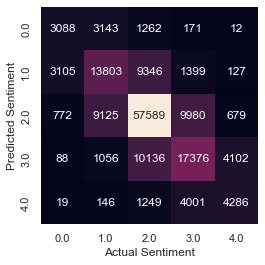

In [9]:
predicted_sentiment = np.array([])
actual_sentiment = np.array([])

for train_i, test_i in skf.split(X, y):
    x_train, y_train = X[train_i], y[train_i]
    x_test, y_test = X[test_i], y[test_i]
    
    classifier = MNB_model.fit(x_train, y_train)
    
    prediction = classifier.predict(x_test)
    
    predicted_sentiment = np.append(predicted_sentiment, prediction)
    actual_sentiment = np.append(actual_sentiment, y_test)
    
mat = confusion_matrix(predicted_sentiment, actual_sentiment)

names = np.unique(predicted_sentiment)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Actual Sentiment')
plt.ylabel('Predicted Sentiment')

### Create the final model from all the training data, and predict the sentiments for the separate prediction data file.

In [10]:
classifier = MNB_model.fit(X, y)

prediction = classifier.predict(X_prediction)
prediction.shape

(66292,)

### Sanity check: Plot the given sentiments of the training data vs. the predicted sentiments of the prediction data.

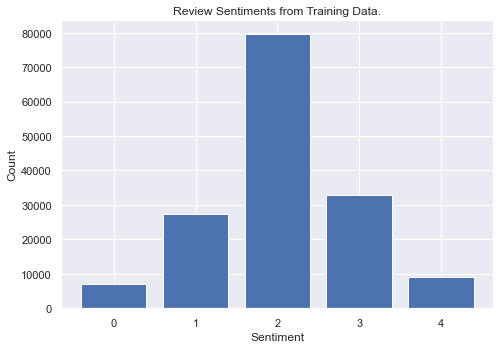

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['0','1','2','3','4']
ax.bar(sentiments, np.bincount(y))
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Review Sentiments from Training Data.")
plt.show()

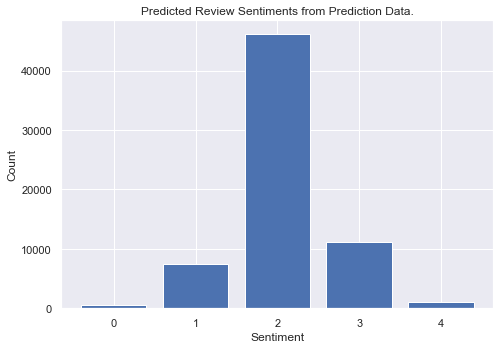

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['0','1','2','3','4']
ax.bar(sentiments, np.bincount(prediction))
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Predicted Review Sentiments from Prediction Data.")
plt.show()

## 4. Evaluation and Conclusions.

Overall, our Multinomial Naive Bayes model for classifying movie reviews, on average, had a 61.65% accuracy rate on each of the 10 testing folds in cross validation. In other words, the sentiment scores for 61.65% of the movie reviews were correctly predicted from our model.

Based on the cross-validation confusion matrix, this model did fairly well in predicting the general "neighborhood" of a review, meaning that for a review with an actual sentiment of n, the model mostly predicted that it would have a sentiment in the range from n-1 to n+1.
+ For example, for reviews with an actual sentiment score of 1, there were (3,143 + 13,803 + 9,125) = 26,071 out of 27,273 reviews that were predicted by the model to have a sentiment score from 0-2.

In terms of predicting the exact sentiment, this model did best in correctly predicting reviews that had a dead-center sentiment of 2, where (57,589 / 79,582) = 72.4% of sentiment 2 reviews in the dataset were correctly predicted.

On the other hand, the model struggled in nailing the exact sentiment beyond reviews in the center.
+ For reviews with sentiments 1 and 3, the model more often incorrectly predicted the sentiment to be 2 than it predicted the sentiment to be the extreme (0 and 4, respectively).
+ For reviews with sentiments 0 and 4, the model made just as many incorrect predictions for the sentiment being 1 and 3 respectively than it made the correct prediction.

Unfortunately, this model seemed to lack the robustness to make good predictions on the entirely separate prediction dataset, as shown in the bar graph above. Compared to the training dataset's sentiment scores, there appear to be an incredibly high number of reviews with a sentiment of 2 vs. all the others in the prediction, while there are very few reviews predicted to have a sentiment of 0 or 4.

According to the Kaggle leaderboard as of right now (and solely based off my training accuracy), this model would place in the ~340th rank out of 860 teams. Above average, but not great, and that's not even based on the accuracy of the prediction data (since the sentiment scores for that is not available to us). I am clearly missing some additional steps and factors to flesh out with more time and resources.

The main source of model improvement that I did focus on in this analysis was trying to capture N-gram phrases where what would have been a "stop word" by default actually adds meaning to the context of the phrase (e.g. the word "not" takes on meaning in "not funny"). From the crude foundation of just taking 1-grams for everything, I was able to find manually that the following stop words added meaning in 2-grams and above: {'becomes', 'besides', 'no', 'not', 'nothing', 'often', 'still', 'too', 'very', 'well'}. 

Potential improvments to the model:
+ Uncover more default stop words that improve the model's accuracy when included in N-grams.
+ Find a way to remove all stop word counts in the data when they are used in 1-grams. In this case, they add no meaning at all.
+ Play around with different classifiers beyond Multinomial Naive Bayes that might make sense.

## Outside Sources Used.

+ https://towardsdatascience.com/sentiment-analysis-introduction-to-naive-bayes-algorithm-96831d77ac91
+ https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
+ https://stackoverflow.com/questions/40124476/how-to-set-custom-stop-words-for-sklearn-countvectorizer
+ https://www.geeksforgeeks.org/bar-plot-in-matplotlib/